<a href="https://colab.research.google.com/github/ChenTaHung/Business-Data-Analytics/blob/master/Business_Data_Analytics_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datatable

     |████████████████████████████████| 59.9MB 51kB/s 
     |████████████████████████████████| 81kB 7.4MB/s 


In [0]:
import pandas as pd
import numpy as np
import datatable as dt

### Import Data from Google Drive (personal account)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
Data = dt.fread("drive/My Drive/Data_For_Model.csv").to_pandas()

In [0]:
# print(Data.shape) # (2402909, 36)
# print(Data.dropna().shape) # (1669220, 36)

In [0]:
# Data.dropna()["LuckyOrNot"].value_counts()
# UnLucky    1588699
# Lucky        80521

### Check Histogram Before and After Dropna




In [0]:
# import matplotlib.pyplot as plt
# plotsize = plt.figure(figsize = (15, 20))
# ax = plotsize.gca()  
# # Data before dropping NaN
# Data.hist(ax = ax)

In [0]:
# plotsize = plt.figure(figsize = (15, 20))
# ax = plotsize.gca()  
# # print("Data after dropping NaN")
# Data.dropna().hist(ax = ax)

> **_Except Age_of_Driver has a little change, but I think the difference is not serious since the age that lower than 20 is not even able to drive a car_**

### Drop Missing Value

In [0]:
# Since the data is adequate, we decided to remove all the row that contains NaN
Data_dropna = Data.dropna()

### Convert Dummy Variables

In [0]:
# Get Dummy Variables
DummyCols = Data.dtypes.index[np.where((Data.dtypes == "object") & (Data.dtypes.index != "LuckyOrNot"))]
Population = pd.get_dummies(data = Data_dropna, columns = DummyCols,dtype = np.int16)
Population.head()
del DummyCols



---



In [7]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Model Sampling

In [0]:
# Since the Response proportion has a huge gap between two labels
# We use Under-sampling (prototype selection)
def Undersampling(data, label) :
  Train = data
  lev1 = Train[label].value_counts().index[0]
  lev2 = Train[label].value_counts().index[1]
  val1 = Train[label].value_counts().values[0]
  val2 = Train[label].value_counts().values[1]

  if val1 > val2 :
    largerSample = lev1
    smallerSample = lev2
    del lev1, lev2
  else :
    largerSample = lev2
    smallerSample = lev1
    del lev1, lev2
  
  LargeSampleData = Train[Train[label] == largerSample]
  SmallSampleData = Train[Train[label] == smallerSample]

  ExtractNrow = SmallSampleData.shape[0]
  subsampleIndex = np.random.randint(0, LargeSampleData.shape[0]-1,ExtractNrow)

  Chosen_LargeSample = LargeSampleData.iloc[subsampleIndex,:]
  Under_Sample_SubSample = pd.concat([SmallSampleData, Chosen_LargeSample], axis = 0)

  return Under_Sample_SubSample
# Function End

UnderSample_population = Undersampling(data = Population, label = "LuckyOrNot")

In [0]:
# Create Train Test Data with constant response term proportion
trainX, testX, trainY, testY = train_test_split(UnderSample_population.iloc[:, 1:], 
                                                UnderSample_population.iloc[:, 0], 
                                                shuffle = True, 
                                                stratify = UnderSample_population.iloc[:, 0],
                                                train_size = 0.7)
# Sampling End

Lencoder = LabelEncoder().fit(["Lucky", "UnLucky"])

### Random Forest in XGB


In [0]:
import xgboost as xgb

In [0]:
Lencoder = LabelEncoder().fit(["Lucky", "UnLucky"])
LabeledtrainY = Lencoder.transform(trainY)
# train_DMatrix = xgb.DMatrix(trainX, LabeledtrainY)

In [0]:
### Train RF with xgboost package
params = {
  'colsample_bynode': 0.5,
  'learning_rate': 0.01,
  'max_depth': 50,
  'num_parallel_tree': 250,
  'objective': 'binary:logistic',
  'subsample': 0.7,
  'tree_method': 'gpu_hist'
}

XGB_RF = xgb.train(params, train_DMatrix, num_boost_round = 1)

In [0]:
Lev1_prob = XGB_RF.predict(xgb.DMatrix(testX))
Res = Lencoder.inverse_transform(np.where(Lev1_prob >=0.5, 1, 0))

In [0]:
# Validate Model
def Scores(true_y, pred_y_prob) :
  Lencoder = LabelEncoder().fit(true_y.value_counts().index)

  trueY_Label = true_y
  trueY_Encode = Lencoder.transform(true_y)
  pred_y_prob = pred_y_prob
  pred_y_Encode = np.where(pred_y_prob >= 0.5, 1, 0)
  pred_y_Label = Lencoder.inverse_transform(pred_y_Encode)

  print("Accuracy : ", metrics.accuracy_score(trueY_Encode, pred_y_Encode))
  print("Recall : ", metrics.recall_score(trueY_Encode, pred_y_Encode))
  print("Precision : ", metrics.precision_score(trueY_Encode, pred_y_Encode))
  print("f1-score : ", metrics.f1_score(trueY_Encode, pred_y_Encode))
  print("Auc :", metrics.roc_auc_score(trueY_Encode, pred_y_prob))

# Scores(testY, Lev1_prob)

In [0]:
import matplotlib.pyplot as plt

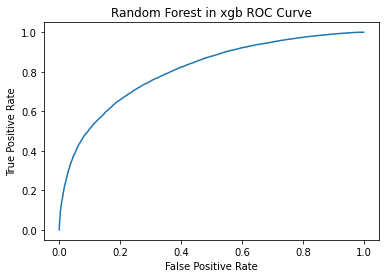

In [0]:
# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(Lencoder.transform(testY), Lev1_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest in xgb ROC Curve")
plt.show()

### CatBoost Classifier (No Need Dummy)


In [10]:
!pip install CatBoost

     |████████████████████████████████| 64.8MB 176kB/s 


In [0]:
from catboost import CatBoostClassifier, Pool

In [0]:
# UnderSampling for Catboost
Data_dropna_underS = Undersampling(Data_dropna, "LuckyOrNot")
# End

# Create Train Test Data with constant response term proportion
catrainX, catestX, catrainY, catestY = train_test_split(Data_dropna_underS.loc[:,Data_dropna.columns != 'LuckyOrNot'], 
                                                        Data_dropna_underS.iloc[:, 27], 
                                                        shuffle = True, 
                                                        stratify = Data_dropna_underS.iloc[:, 27],
                                                        train_size = 0.7)
# End

In [0]:
# Create Pool train test data for catboost
categorical_features_indices = np.where(catrainX.dtypes != np.float)[0]
train_pool = Pool(catrainX, catrainY, cat_features=categorical_features_indices)
test_pool = Pool(catestX, cat_features=categorical_features_indices)
# End

In [25]:
# Fit the Model!
catboost_model = CatBoostClassifier(iterations=1000, 
                                    loss_function = "Logloss",
                                    custom_metric = "AUC",
                                    learning_rate = 0.1,
                                    bootstrap_type = "Bayesian",
                                    depth = 5,
                                    min_data_in_leaf = 1, 
                                    task_type = "GPU",
                                    silent = True)

catboost_model.fit(train_pool)

In [0]:
# Predict (Put into `Score` function)
# cat_pred_label = catboost_model.predict(test_pool, prediction_type="Class")
# cat_pred_prob = catboost_model.predict(test_pool, prediction_type="Probability")
# catboost_res_DF = pd.DataFrame(cat_pred_prob, columns=["Lucky", "UnLucky"]).assign(Label = cat_pred_label)

In [0]:
# Score Score Score
def Cat_boost_model_Score(estimator) :
  cat_pred_label = estimator.predict(test_pool, prediction_type="Class")
  cat_pred_prob = estimator.predict(test_pool, prediction_type="Probability")
  catboost_res_DF = pd.DataFrame(cat_pred_prob, columns=["Lucky", "UnLucky"]).assign(Label = cat_pred_label)
  # Accuracy
  print("Accuracy:",estimator.score(X = catestX, y = catestY))
  # AUC
  fpr, tpr, thresholds = metrics.roc_curve(np.where(catestY == "Lucky", 1, 0), catboost_res_DF["Lucky"])
  print("AUC: ", metrics.auc(fpr, tpr))
  # Recall
  print("Recall:", metrics.recall_score(Lencoder.transform(catestY), Lencoder.transform(cat_pred_label)))
  # Precision
  print("Precision:", metrics.precision_score(Lencoder.transform(catestY), Lencoder.transform(cat_pred_label)))
  # f1-score
  print("f1 Score:",metrics.f1_score(catestY, cat_pred_label, pos_label="Lucky"))

In [26]:
# Score!
Cat_boost_model_Score(catboost_model)

Accuracy: 0.7264090410448534
AUC:  0.8031273312380951
Recall: 0.6988739857592317
Precision: 0.7395951984578989
f1 Score: 0.7337442591249698


In [0]:
import matplotlib.pyplot as plt

In [0]:
VarImpShap = catboost_model.get_feature_importance(data = train_pool, type="ShapValues")
VarImp = catboost_model.get_feature_importance(data = train_pool)
CatVarImpDF = pd.DataFrame({"Feature" : catrainX.columns, "Importance" : VarImp})

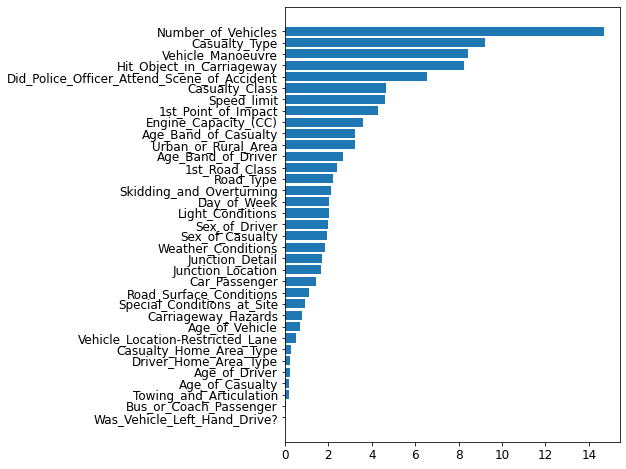

In [29]:
plt.figure(figsize=(6,8))
plt.barh(CatVarImpDF.sort_values(by="Importance")["Feature"], CatVarImpDF.sort_values(by="Importance")["Importance"])
plt.tick_params(labelsize=12)
plt.show()

#### Shap Value Interpretation! (CatBoostClassifier)

In [30]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394103 sha256=72f481b9ffed1e9e382c5f70d7b5cb315a21644d4a12eafafd3061fc4d63d0b4
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [31]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(catestX) 
shap.force_plot(explainer.expected_value, shap_values[0,:], catestX.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


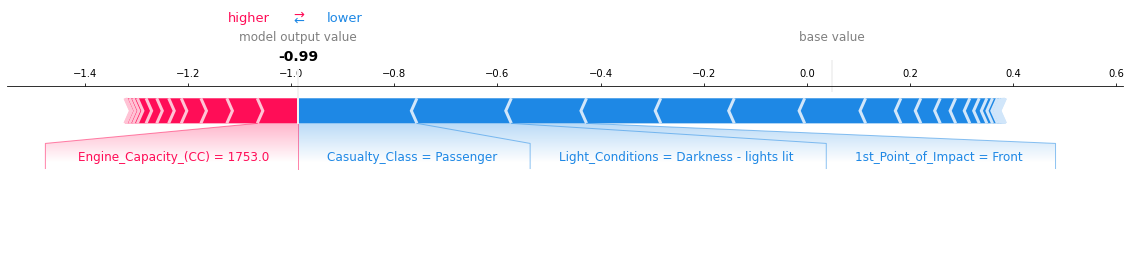

In [39]:
shap.force_plot(explainer.expected_value, shap_values[0,:], catestX.iloc[0,:], matplotlib = True)

In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:100,:], catestX.iloc[0:100, :])

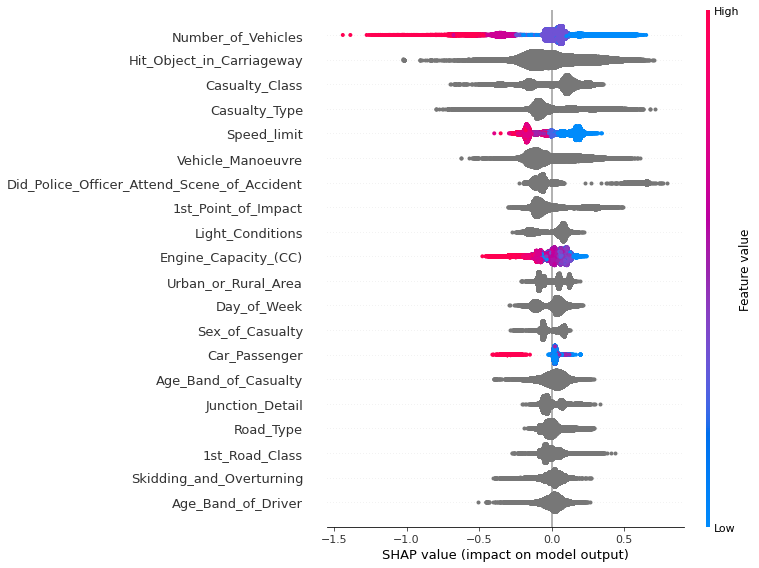

In [36]:
shap.summary_plot(shap_values, catestX)

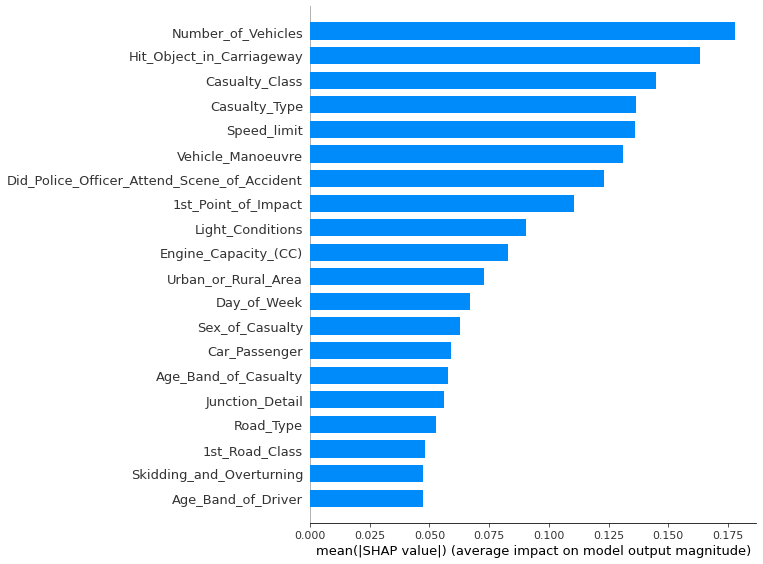

In [37]:
shap.summary_plot(shap_values, catestX, plot_type="bar")

### Grid Search CV Catboost

In [14]:
### GridSearchCV
from sklearn.model_selection import GridSearchCV
parms = {"learning_rate" : [1, 0.5, 0.1],
         "iterations" : [750, 1000, 1250],
         "depth" :[3,5,7]}
catboost_model_grid = CatBoostClassifier(loss_function = "Logloss",
                                         custom_metric = "F1",
                                         task_type = "GPU", 
                                         cat_features = categorical_features_indices,
                                         min_data_in_leaf = 1,
                                         silent = True)
Grid_Catboost = GridSearchCV(estimator = catboost_model_grid, param_grid = parms, cv = 5, n_jobs = 1)
Grid_Catboost.fit(catrainX, catrainY)

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n", Grid_Catboost.best_estimator_)
    
print("\n The best score across ALL searched params:\n", Grid_Catboost.best_score_)
    
print("\n The best parameters across ALL searched params:\n", Grid_Catboost.best_params_)
    
print("\n ========================================================")

# ========================================================
#  Results from Grid Search 
# ========================================================
 
#  The best estimator across ALL searched params:
#  <catboost.core.CatBoostClassifier object at 0x7f46b8d864a8>

#  The best score across ALL searched params:
#  0.7259888825009236

#  The best parameters across ALL searched params:
#  {'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}

#  ========================================================


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7259888825009236

 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}



In [20]:
# Best Esrimator Fit!
Cat_boost_model_Score(Grid_Catboost.best_estimator_)

# Accuracy: 0.7266781197607269
# AUC:  0.8045542831278494
# Recall: 0.6930910295152544
# Precision: 0.7430105618176978
# f1 Score: 0.735556223090017

Accuracy: 0.7266781197607269
AUC:  0.8045542831278494
Recall: 0.6930910295152544
Precision: 0.7430105618176978
f1 Score: 0.735556223090017
